In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
import nltk

In [4]:
df=pd.read_csv('Data.csv', encoding = "ISO-8859-1")

In [5]:
train = df[df['Date'] < '20150101']
test = df[df['Date'] > '20141231']

In [6]:
text_columns = df.columns[2:] 

In [7]:
for column in text_columns:
    train[column] = train[column].astype(str).fillna('')
    test[column] = test[column].astype(str).fillna('')

C:\Users\abhit\AppData\Local\Temp\ipykernel_30640\571503842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[column] = train[column].astype(str).fillna('')
C:\Users\abhit\AppData\Local\Temp\ipykernel_30640\571503842.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[column] = test[column].astype(str).fillna('')
C:\Users\abhit\AppData\Local\Temp\ipykernel_30640\571503842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [8]:
train['combined_text'] = train[text_columns].agg(' '.join, axis=1)
test['combined_text'] = test[text_columns].agg(' '.join, axis=1)

C:\Users\abhit\AppData\Local\Temp\ipykernel_30640\708268268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['combined_text'] = train[text_columns].agg(' '.join, axis=1)
C:\Users\abhit\AppData\Local\Temp\ipykernel_30640\708268268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['combined_text'] = test[text_columns].agg(' '.join, axis=1)


In [12]:
lemmatizer = WordNetLemmatizer()

In [13]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Tokenize and lemmatize
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [14]:
train['processed_text'] = train['combined_text'].apply(preprocess_text)
test['processed_text'] = test['combined_text'].apply(preprocess_text)


C:\Users\abhit\AppData\Local\Temp\ipykernel_30640\1159508351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['processed_text'] = train['combined_text'].apply(preprocess_text)
C:\Users\abhit\AppData\Local\Temp\ipykernel_30640\1159508351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['processed_text'] = test['combined_text'].apply(preprocess_text)


In [16]:
y_train = train['Label'].values
y_test = test['Label'].values

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['processed_text'])  # Fit on training data only
train_sequences = tokenizer.texts_to_sequences(train['processed_text'])
test_sequences = tokenizer.texts_to_sequences(test['processed_text'])

In [24]:
max_l = 0
for i in range(train.shape[0]):
    if max_l<len(train['combined_text'][1943]):
        max_l=len(train['combined_text'][1943])
print(max_l)

1029


In [25]:
maxlen = 1020  
train_padded = pad_sequences(train_sequences, maxlen=maxlen)
test_padded = pad_sequences(test_sequences, maxlen=maxlen)

In [26]:
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 100  # Size of the embedding vector

In [27]:
print("Training data shape:", train_padded.shape)
print("Testing data shape:", test_padded.shape)
print("Number of unique words (vocabulary size):", vocab_size)

Training data shape: (3975, 1020)
Testing data shape: (378, 1020)
Number of unique words (vocabulary size): 48091


In [28]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [29]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model.fit(train_padded, y_train, epochs=5, batch_size=32, validation_data=(test_padded, y_test))

Epoch 1/5


125/125 [==============================] - 130s 1s/step - loss: 0.6927 - accuracy: 0.5197 - val_loss: 0.6880 - val_accuracy: 0.5106
Epoch 2/5
125/125 [==============================] - 125s 1s/step - loss: 0.5519 - accuracy: 0.7082 - val_loss: 0.4109 - val_accuracy: 0.8148
Epoch 3/5
125/125 [==============================] - 117s 932ms/step - loss: 0.1199 - accuracy: 0.9565 - val_loss: 0.4663 - val_accuracy: 0.8307
Epoch 4/5
125/125 [==============================] - 116s 928ms/step - loss: 0.0181 - accuracy: 0.9945 - val_loss: 0.6486 - val_accuracy: 0.8466
Epoch 5/5
125/125 [==============================] - 118s 948ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.8737 - val_accuracy: 0.8386


In [32]:
loss, accuracy = model.evaluate(test_padded, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

12/12 [==============================] - 3s 247ms/step - loss: 0.8737 - accuracy: 0.8386
Test Accuracy: 0.84


12/12 [==============================] - 3s 210ms/step


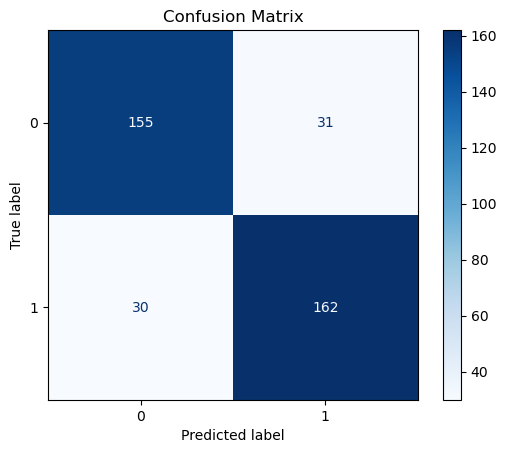

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_pred_prob = model.predict(test_padded)
y_pred = (y_pred_prob > 0.5).astype(int) 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()